# Features selection

Cheryl KOUADIO  
2024-10-19

# Activity 1 : Mutual Information and HSIC

Feature selection is a process where you automatically or manually
select those features which contribute most to your prediction variable
or output in which you are interested in. Having irrelevant features in
your data can decrease the accuracy of the models and make your model
learn based on irrelevant features, therefore, it is important to select
only the relevant features.

The usual tools used for features selection are based on correlation
tests such as Pearson correlation or Spearman correlation when the
variables are quantitatives or the Chi-Square test when the variables
are qualitatives. However, these do not take in the account the
relationship between quantitative and qualitatives variables. Moreover,
for the pearson correlation or the spearman one, we are only interested
in the linear(pearson) or monotonic(spearman) relationship between the
variables.

In this notebook, we are interested in measuring any kind of
relationship between variables, no matter what type of variables they
are. For that, we will introduce the mutual information, based on the
Kullback-Leibler divergence, which is a measure of the divergence
between the joint distribution of X and Y and the product of their
marginal distributions :

$$I(X;Y) = \int_{X} \int_{Y} p(x,y) \log \left( \frac{p(x,y)}{p(x)p(y)} \right)$$

where $p(x,y)$ is the joint probability distribution function of X and
Y, and $p(x)$ and $p(y)$ are the marginal probability distribution
functions of X and Y. If the variables are independent, then the mutual
information is equal to 0. If the variables are dependent, then the
mutual information is greater than 0.

In order to have confidence in this measure, we will consider a
bivariate gaussian variable $Z=(X,Y)$ with mean $\mu = (0,0)$ and
covariance matrix
$\Sigma = \begin{pmatrix} \sigma^2_X & \rho \sigma_X \sigma_X \\  \rho \sigma_X \sigma_X & \sigma^2_Y \end{pmatrix}$.
We will compute the mutual information between X and Y for a grid a
$\rho$ between 0.01 and 0.99 using 1000 size samples repeated 100 times
and see how the mutual information behaves and compare it the theorical
value of the mutual information which is equal to
$-\frac{1}{2} \log(1-\rho^2)$.

## 1. Accuracy of mutual information estimation

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns


# Function to generate bivariate Gaussian data
def generate_bivariate_gaussian(n, rho):
    mu_X, mu_Y = np.random.normal(0, 1), np.random.normal(0, 1)
    sigma_X, sigma_Y = np.random.chisquare(1), np.random.chisquare(1)
    mean = [mu_X, mu_Y]
    cov = [[sigma_X**2, rho * sigma_X * sigma_Y], 
           [rho * sigma_X * sigma_Y, sigma_Y**2]]
    return np.random.multivariate_normal(mean, cov, size=n)

# Function to compute true mutual information
def true_mutual_information(rho):
    return -0.5 * np.log(1 - rho**2)

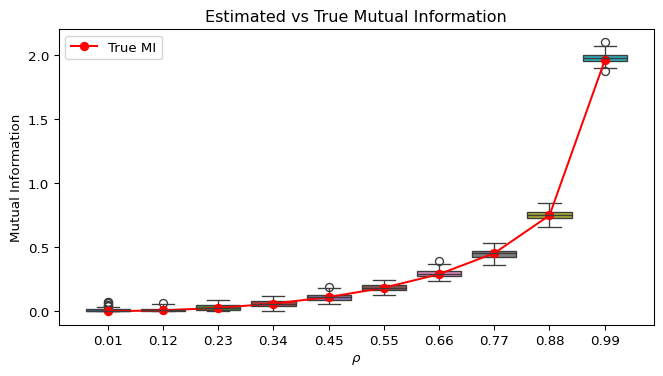

In [2]:
# Initialize parameters
n_samples = 1000
n_repeats = 100
rho_values = np.linspace(0.01, 0.99, 10)

# Store mutual information estimates
estimated_mi = []
true_mi_values = []

for rho in rho_values:
    mi_estimates = []
    for _ in range(n_repeats):
        # Generate data
        data_test = generate_bivariate_gaussian(n_samples, rho)
        X = data_test[:, 0].reshape(-1, 1)  # Feature
        Y = data_test[:, 1]  # Target
        
        # Estimate mutual information
        mi = mutual_info_regression(X, Y, discrete_features=False)
        mi_estimates.append(mi[0])  # mutual_info_regression returns an array
        
    # Store results
    estimated_mi.append(mi_estimates)
    true_mi_values.append(true_mutual_information(rho))

# Convert estimated MI to array for easy plotting
estimated_mi = np.array(estimated_mi)

# Plot boxplots of the estimated MI for each value of rho
plt.figure(figsize=(8, 4))
sns.boxplot(data=estimated_mi.T)
plt.plot(np.arange(len(rho_values)), true_mi_values, color='red', marker='o', linestyle='-', label="True MI")
plt.xticks(ticks=np.arange(len(rho_values)), labels=[f'{rho:.2f}' for rho in rho_values])
plt.xlabel(r'$\rho$')
plt.ylabel('Mutual Information')
plt.title('Estimated vs True Mutual Information')
plt.legend()
plt.show()

As we can see in the graph above, the mutual information is able to
capture the relationship between the variables, even if they are not
linearly related. In fact, as the parameter $\rho$ increases, the mutual
information increases as well. Morever, between the theoretical value of
the mutual information and the empirical one, we can see that they are
very close to each other. Hence, the function `mutual_info_regression`
is well implemented and can be used to select the relevant features in a
dataset.

## 2. Comparison between mutual information and correlation tests

We will use a simulate dataset where we know the relationship between
the variables and see how the pearson, spearman an mutual information
perform. We will consider a dataset where the 15 first variables are
normal $X_{i = 1,\dots,15} \sim \mathcal{N}(0,1)$ and the 5 last
variables are uniform $X_{i = 16,\dots,20} \sim \mathcal{U}(0,1)$. We
will consider the target variable $Y$ as a linear combination of some
variables :

$$ Y = 2X_1 + X_7^2 + X_4^3 + 3 X_2 X_{11} + 2 \sin(2\pi X_{19}) + 3X_6^2\cos(2\pi X_{17})$$

In [3]:
# Function to generate data
def generate_data(n):
    data = pd.DataFrame()
    for i in range(15):
        data[f"X{i+1}"] = np.random.normal(0, 1, n)
        
    for i in range(5):
        data[f"X{i+16}"] = np.random.uniform(0, 1, n)
    pi = math.pi
    data["Y"] = 2 * data["X1"] + data["X7"]**2 + data["X4"]**3 + 3 * data["X2"] * data["X11"] + \
                2 * np.sin(2 * pi * data["X19"]) + 3 * (data["X6"]**2) * np.cos(2 * pi * data["X10"])
                
    return data

In [4]:
# compute the correlation between each feature and the target
from scipy.stats import pearsonr, spearmanr

concat_spearman = []
concat_pearson = []

for sim in range(50):
    data = generate_data(500)
    spearman_corr = [spearmanr(data[col], data["Y"])[0] for col in data.columns[:-1]]
    pearson_corr = [pearsonr(data[col], data["Y"])[0] for col in data.columns[:-1]]
    concat_spearman.append(np.abs(spearman_corr))
    concat_pearson.append(np.abs(pearson_corr))

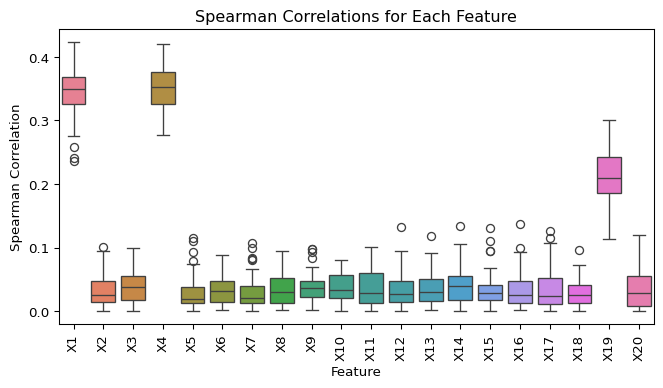

In [5]:
import pandas as pd

feature_names = data.columns[:-1]  # Get feature names from the dataset

spearman_df = pd.DataFrame(concat_spearman, columns=feature_names)
pearson_df = pd.DataFrame(concat_pearson, columns=feature_names)

# Spearman correlations
plt.figure(figsize=(8, 4))
sns.boxplot(data=spearman_df)
plt.title('Spearman Correlations for Each Feature')
plt.ylabel('Spearman Correlation')
plt.xlabel('Feature')
plt.xticks(rotation=90) 
plt.show()

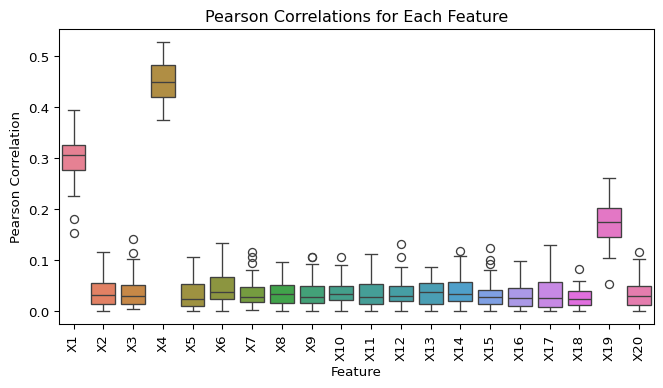

In [6]:
# Pearson correlations
plt.figure(figsize=(8, 4))
sns.boxplot(data=pearson_df)
plt.title('Pearson Correlations for Each Feature')
plt.ylabel('Pearson Correlation')
plt.xlabel('Feature')
plt.xticks(rotation=90) 
plt.show()

As we can see, the spearman and pearson correlation can not identify all
the relevant features, in fact, they are only able to identify the
relevant variables $X_1$, $X_4$ and $X_{19}$ related to the target
variable $Y$. If we are interested in selecting the relevant features
using the mutual information, we can identify more relevant features
such as $X_1$, $X_4$, $X_6$, $X_7$, and $X_{19}$, however some
irrelevant features are also selected such as $X_2$ and $X_{11}$.

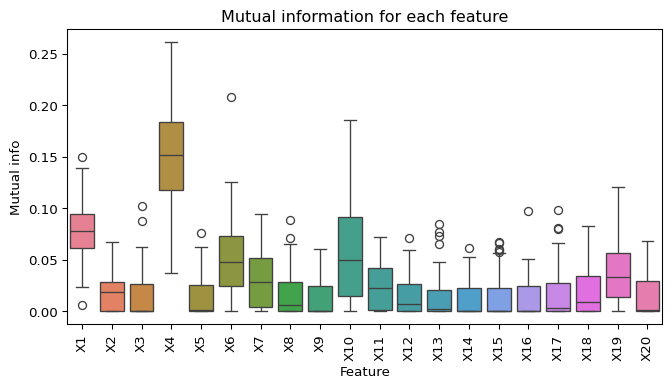

In [7]:
mutual_info = []

for sim in range(50):
    data = generate_data(500)
    mi_corr = [mutual_info_regression(data[[col]], data["Y"], discrete_features=False)[0] for col in data.columns[:-1]]
    mutual_info.append(mi_corr)

mutual_info = pd.DataFrame(mutual_info, columns=feature_names)

# Plotting boxplots for Spearman correlations
plt.figure(figsize=(8, 4))
sns.boxplot(data=mutual_info)
plt.title('Mutual information for each feature')
plt.ylabel('Mutual info')
plt.xlabel('Feature')
plt.xticks(rotation=90)  # Rotate feature names if there are many features
plt.show()

To conclude, the mutual information seems to be a good tool to select
the relevant features in a dataset. In fact, it is able to capture the
relationship between the variables, no matter what type of variables
they are.

### What about feature selection with lasso regression?

We might be interested in the behavior of the lasso regression in the
same dataset. We will use the `Lasso` class from the
`sklearn.linear_model` module to fit the lasso regression on the dataset
and see how it performs in selecting the relevant features. We will use
the `LassoCV` class to select the best value of the regularization
parameter $\alpha$ using cross-validation.

In [8]:
from sklearn.linear_model import LassoCV
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

n_simulations = 50
n_samples = 500
n_features = data.shape[1] - 1  

selected_features = np.zeros((n_simulations, n_features))
scaler = StandardScaler()
for sim in range(n_simulations):
    # Generate data
    data = generate_data(n_samples)
    X = data.drop(columns=["Y"]) 
    X_scaled = scaler.fit_transform(X)
    y = data["Y"] 
    
    lasso = LassoCV().fit(X_scaled, y)
    
    selected_features[sim, :] = (lasso.coef_ != 0).astype(int)

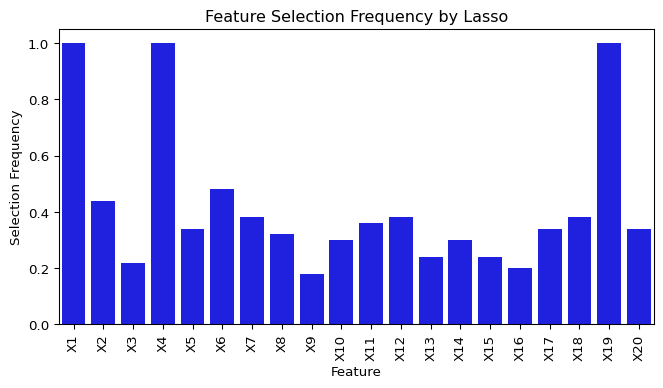

In [9]:
# Frequency of selection for each feature
selection_frequency = np.mean(selected_features, axis=0)

# Create a DataFrame for better visualization
selection_df = pd.DataFrame({
    'Feature': X.columns,
    'Selection Frequency': selection_frequency
})


# You can also visualize this with a bar plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.barplot(x='Feature', y='Selection Frequency', data=selection_df,color="blue")
plt.title('Feature Selection Frequency by Lasso')
plt.xticks(rotation=90)
plt.show()

As we can see, the lasse regression is able to select the relevant
features in the dataset. However, it is not able to select all the
relevant features, hence it might always be interesting to use the
mutual information (combined with lasso regression or other correlations
tests) to select the relevant features in a dataset.

## 3. Hilbert-Schmidt Independence Criterion

We can also use the kernel trick applied to the kullback-leibler
divergence to measure the mutual information between the variables. This
is called the Maximum Mean Discrepancy (MMD) and is defined as :

$$MMD^2(X,Y) = \mathbb{E}_{x,x' \sim X} [k(x,x')] + \mathbb{E}_{y,y' \sim Y} [k(y,y')] - 2 \mathbb{E}_{x \sim X, y \sim Y} [k(x,y)]$$

where $k$ is a kernel function. The MMD is equal to 0 if and only if the
two distributions are equal. We can use the `MMD` class from the
`sklearn.metrics.pairwise` module to compute the MMD between the
variables. For a continuous variables, this writes :

$$MMD^2(X,Y) = \int_X k(x,x') \left[ p(x) - q(x)\right] \left[ p(x') - q(x')\right] dxdx'$$

where $p$ and $q$ are the probability distribution functions of X and Y.

This is also defined as the Hilbert-Schmidt Independence Criterion
(HSIC) when we are interested in the measure of divergence between the
joint distribution of X and Y and the product of their marginal
distributions. The estimate of the HSIC is given by :

$$HSIC(X,Y) = \frac{1}{n^2} \text{tr}(KHLH)$$

where $K$ is the kernel matrix of X and $L$ is the kernel matrix of Y
and H is the centering matrix
$H = I - \frac{1}{n} \mathbf{1} \mathbf{1}^T$. Since the HSIC is not
implemented in the mainstream libraries, we will implement it ourselves
using the sobolev kernel for X and Y with :

$$k(x,x') = 1 + (z_i - 0.5) (z_j - 0.5) + \frac{1}{2} ((z_i-z_j)^2 - |z_i -z_j| +1/6)$$

In [10]:
def sobolev_kernel(x,y):
    return 1 + (x - 0.5)*(y - 0.5) + (1/2)*( (x-y)**2 - np.abs(x-y) + 1/6)

def compute_gram_matrix(z):
    z = np.asarray(z)
    M = sobolev_kernel(z[:,None],z[None,:])
    return M

def hsic(X, Y):
    n = X.shape[0]
    H = np.eye(n) - (1 / n) * np.ones((n, n))

    # Compute Gram matrices with Sobolev kernel
    K = compute_gram_matrix(X)
    L = compute_gram_matrix(Y)

    # Calculate HSIC
    hsic_value = (1 / (n - 1) ** 2) * np.trace(K @ H @ L @ H)
    return hsic_value

In [11]:
from sklearn.preprocessing import MinMaxScaler

hsic_values = []

for sim in range(50):
    data = generate_data(500)
    scaler = MinMaxScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    hsic_var = [hsic(data_scaled[col], data_scaled["Y"]) for col in data.columns[:-1]]
    hsic_values.append(hsic_var)

hsic_df = pd.DataFrame(hsic_values, columns=feature_names)

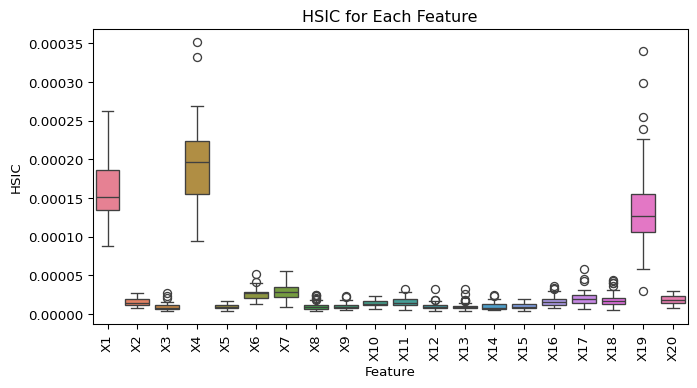

In [12]:
# Plotting boxplots for Spearman correlations
plt.figure(figsize=(8, 4))
sns.boxplot(data=hsic_df)
plt.title('HSIC for Each Feature')
plt.ylabel('HSIC')
plt.xlabel('Feature')
plt.xticks(rotation=90)  # Rotate feature names if there are many features
plt.show()

## Threshold selection for mutual information and HSIC

The hilbert-schmidt independence criterion, the mutual information are
able to capture the relationship between the variables, no matter what
type of variables they are. However, it needs a definition of a
threshold to select the relevant features in a dataset. As for
correlation tests like pearson or speaman, we might use statistical
tests to select the relevant features in a dataset. However, for mutual
information and HSIC, we use the permutation test where the test
statistic distribution under the null hypothesis (X and Y are
independent), is estimated with several data permutations. The p-value
is then computed as the proportion of test statistics that are more
extreme than the observed test statistic.

In [13]:
from sklearn.utils import resample
data = generate_data(500)

Y = data["Y"]
X = data.drop(columns=["Y"])

scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
X_scaled = data_scaled.drop(columns=["Y"])
Y_scaled = data_scaled["Y"]

mi_train = mutual_info_regression(X, Y)

n_rep = 500
all_miXYindep = np.zeros((n_rep, n_features))
all_HSICindep = np.zeros((n_rep, n_features))

for rep in range(n_rep):
    # Permutation
    yb = resample(Y, replace = False)
    # Compute mutual information between all features and Y
    mi_temp = mutual_info_regression(X, np.ravel(yb))
    # Store the MI from this repetition
    all_miXYindep[rep, :] = mi_temp
    # Permutation
    yb_train = resample(Y_scaled, replace = False)


p_values_mi = np.mean(mi_train < all_miXYindep, axis=0)

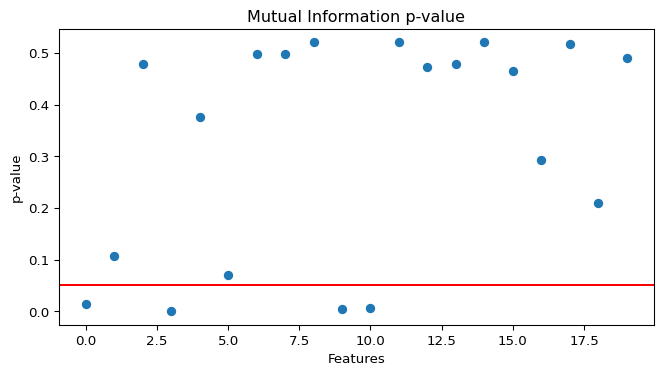

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(p_values_mi, 'o')
plt.title('Mutual Information p-value')
plt.axhline(y=0.05, color='r', linestyle='-')
plt.xlabel('Features')
plt.ylabel('p-value')
plt.show()

Depending on the pvalues, we can select the relevant features in a
dataset. Using the mutual information, the variables selected are listed
below :

In [15]:
print("Selected variables with MI p-values %s " % np.where(p_values_mi < 0.05))

Selected variables with MI p-values [ 0  3  9 10] 